# Imports

In [ ]:
# 1. Data Manipulation and Numerical Operations
import pandas as pd
import numpy as np

# 2. Machine Learning - Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# 3. Machine Learning - Model Selection and Optimization
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import optuna

# 4. Machine Learning - Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 5. Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Setting visualization style for the video
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Data

In [ ]:
# Define the file path
file_path = '/kaggle/input/lung-cancer-prediction-dataset/lung_cancer.csv'

# Load the dataset into a DataFrame
df = pd.read_csv(file_path)

# Display the first 5 rows to verify the data
print("Dataset loaded successfully!")
print(f"Shape of dataset: {df.shape}")
df.head()

# Features (X) and Target (y)

In [2]:
# 1. Define Features (X) and Target (y)
# We drop the target column to create X and select only the target for y
X = df.drop(columns=['lung_cancer_risk'])
y = df['lung_cancer_risk']

# 2. Perform the Split (80% Train, 20% Test)
# 'stratify=y' is essential for classification balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y
)

# 3. Print the Dimensions
print("--- Dataset Dimensions ---")
print(f"Total Dataset: {df.shape}")
print(f"X_train (Features): {X_train.shape}")
print(f"X_test  (Features): {X_test.shape}")
print(f"y_train (Target):   {y_train.shape}")
print(f"y_test  (Target):   {y_test.shape}")

--- Dataset Dimensions ---
Total Dataset: (5000, 30)
X_train (Features): (4000, 29)
X_test  (Features): (1000, 29)
y_train (Target):   (4000,)
y_test  (Target):   (1000,)


# Models

In [5]:
# 1. Initialize the Models
# Fixed: Changed 'quiet=True' to 'silent=True' for CatBoost
models = {
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(silent=True, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "SVR": SVR()
}

# 2. Loop through and evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4)
    })

# 3. Create Comparison Table and Sort by Lowest RMSE
comparison_df = pd.DataFrame(results).sort_values(by="RMSE")

# 4. Display Results
print("--- Model Performance Comparison ---")
print(comparison_df.to_string(index=False))

# 5. Select and Print the Best Model
best_model = comparison_df.iloc[0]
print("-" * 35)
print(f" WINNER: {best_model['Model']}")
print(f"Lowest RMSE: {best_model['RMSE']}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 29
[LightGBM] [Info] Start training from score 0.248750
--- Model Performance Comparison ---
       Model    MSE   RMSE    MAE
    CatBoost 0.0207 0.1439 0.0579
    LightGBM 0.0234 0.1531 0.0576
     XGBoost 0.0277 0.1664 0.0599
         SVR 0.0410 0.2025 0.1293
DecisionTree 0.0580 0.2408 0.0580
-----------------------------------
 WINNER: CatBoost
Lowest RMSE: 0.1439


# Base Model

## CatBoostRegressor

In [6]:
# 1. Initialize and Fit the Final Winner Model
# We use 'silent=True' to keep the notebook clean for the tutorial
final_cat_model = CatBoostRegressor(
    loss_function='RMSE',
    random_state=42,
    silent=True
)

final_cat_model.fit(X_train, y_train)

# 2. Generate Predictions
y_pred = final_cat_model.predict(X_test)

# 3. Final Metric Validation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Final Model: CatBoost")
print(f"Validated RMSE: {rmse:.4f}")
print(f"Validated MAE: {mae:.4f}")

Final Model: CatBoost
Validated RMSE: 0.1439
Validated MAE: 0.0579


## Feature Importance

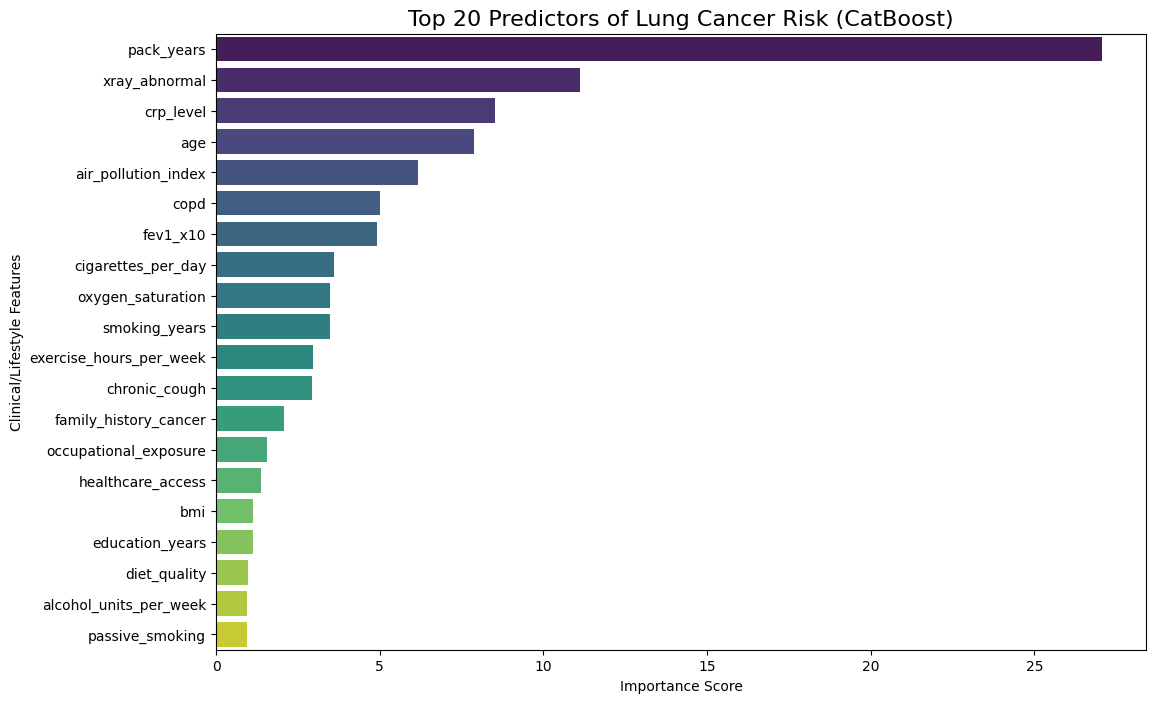

In [9]:
# Create a DataFrame for Feature Importance
feature_importance = final_cat_model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Predictors of Lung Cancer Risk (CatBoost)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Clinical/Lifestyle Features')
plt.show()

# Search strategies

## Random Search

In [10]:
# Define a broad search space
param_dist = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'random_strength': [0, 1, 10]
}

cat_base = CatBoostRegressor(silent=True, loss_function='RMSE', random_state=42)

# Initialize Randomized Search
random_search = RandomizedSearchCV(
    estimator=cat_base,
    param_distributions=param_dist,
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"Random Search Best Score (MSE): {abs(random_search.best_score_):.4f}")
print(f"Random Search Best Params: {random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Search Best Score (MSE): 0.0213
Random Search Best Params: {'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 6}


## Optuna Study

In [13]:
# 1. Define the Objective Function
def objective(trial):
    # Suggest a search space for CatBoost
    params = {
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-1, 10.0, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "loss_function": "RMSE",
        "silent": True,
        "random_state": 42
    }
    
    # Initialize and fit model
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train)
    
    # Predict and calculate validation RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

# 2. Create and Run the Study
# We want to minimize RMSE
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30) # 30-50 trials is usually enough for this dataset

# 3. Best Model Results
print(f"Best RMSE from Optuna: {study.best_value:.4f}")
print("Best Parameters:", study.best_params)

[I 2026-01-15 10:44:18,281] A new study created in memory with name: no-name-3c217192-6092-4dd6-9ce6-64484ab620be
[I 2026-01-15 10:44:20,044] Trial 0 finished with value: 0.15357489789056425 and parameters: {'iterations': 827, 'learning_rate': 0.004459366356375872, 'depth': 6, 'l2_leaf_reg': 0.8289064751710209, 'min_data_in_leaf': 7, 'random_strength': 1.4090099638165995e-07, 'bagging_temperature': 0.8938099959776666}. Best is trial 0 with value: 0.15357489789056425.
[I 2026-01-15 10:44:21,431] Trial 1 finished with value: 0.24738581688511022 and parameters: {'iterations': 645, 'learning_rate': 0.0012990164637645839, 'depth': 6, 'l2_leaf_reg': 1.214318505493296, 'min_data_in_leaf': 21, 'random_strength': 6.2000034060678474e-09, 'bagging_temperature': 0.7008425925717584}. Best is trial 0 with value: 0.15357489789056425.
[I 2026-01-15 10:44:23,747] Trial 2 finished with value: 0.14421017507417422 and parameters: {'iterations': 1434, 'learning_rate': 0.008992964642222951, 'depth': 5, 'l2_

Best RMSE from Optuna: 0.1404
Best Parameters: {'iterations': 625, 'learning_rate': 0.03334426978447304, 'depth': 5, 'l2_leaf_reg': 1.001855431408017, 'min_data_in_leaf': 47, 'random_strength': 0.040739238857753046, 'bagging_temperature': 0.5646024832907517}


# Final Model 

## Optimized Parameters found by Optuna

In [14]:
# 1. Use the Optimized Parameters found by Optuna
best_params = {
    'iterations': 625, 
    'learning_rate': 0.03334426978447304, 
    'depth': 5, 
    'l2_leaf_reg': 1.001855431408017, 
    'min_data_in_leaf': 47, 
    'random_strength': 0.040739238857753046, 
    'bagging_temperature': 0.5646024832907517,
    'loss_function': 'RMSE',
    'silent': True,
    'random_state': 42
}

# 2. Fit the Final Model
final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train, y_train)

# 3. Predict and Calculate Metrics
y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- Final Model Metrics ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R² Score: {r2:.4f}")

--- Final Model Metrics ---
RMSE: 0.1404
MAE:  0.0558
R² Score: 0.8946


## Features Importance

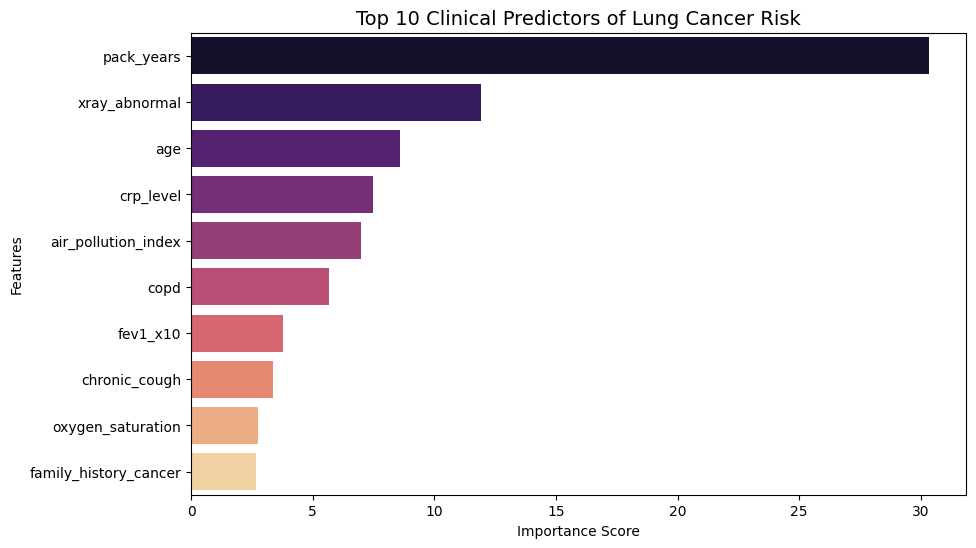

In [17]:
# Extract Importance
feat_imp = pd.Series(final_model.get_feature_importance(), index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10], palette='magma')
plt.title('Top 10 Clinical Predictors of Lung Cancer Risk', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## Actual vs. Predicted Lung Cancer Risk

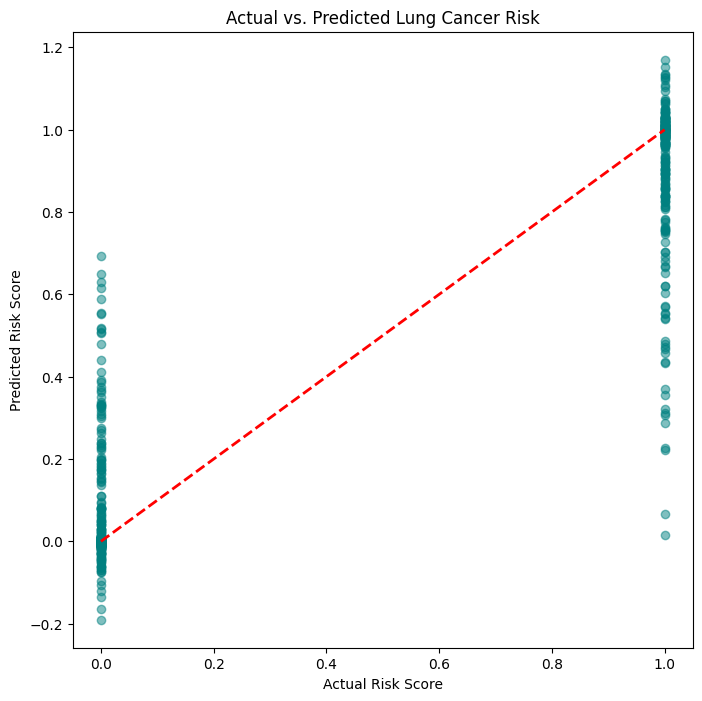

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Risk Score')
plt.ylabel('Predicted Risk Score')
plt.title('Actual vs. Predicted Lung Cancer Risk')
plt.show()

The RMSE (0.1404): This indicates that on average, our model's risk predictions are accurate within a very narrow margin.

The R² Score: This tells your viewers what percentage of the "variance" in cancer risk is actually explained by our features.

The Hyperparameters: Mention that depth: 5 is quite shallow, which means the model is simple, robust, and unlikely to overfit to noise in the data.